### Machine Learning

**XG Boost**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df_airlines = pd.read_csv('../data/ontime_2025.csv')
df_airlines.head(5)

,year,month,day_of_month,day_of_week,op_unique_carrier,op_carrier_airline_id,op_carrier_fl_num,origin,origin_city_name,origin_state_abr,...,carrier_delay,weather_delay,nas_delay,security_delay,dep_time_dt,arr_time_dt,dep_bin,season,delay_category,fl_date
0,2024,11,1,5,9E,20363,4800,CLT,"Charlotte, NC",NC,...,6.0,0.0,0.0,0.0,1900-01-01 18:28:00,1900-01-01 20:15:00,Early Evening,Autumn,Moderate Delay,2024-11-01
1,2024,11,1,5,9E,20363,4801,CVG,"Cincinnati, OH",KY,...,0.0,0.0,0.0,0.0,1900-01-01 17:41:00,1900-01-01 18:49:00,Afternoon,Autumn,On Time,2024-11-01
2,2024,11,1,5,9E,20363,4802,DSM,"Des Moines, IA",IA,...,0.0,0.0,0.0,0.0,1900-01-01 15:54:00,1900-01-01 16:57:00,Afternoon,Autumn,On Time,2024-11-01
3,2024,11,1,5,9E,20363,4803,CVG,"Cincinnati, OH",KY,...,0.0,0.0,0.0,0.0,1900-01-01 13:50:00,1900-01-01 14:55:00,Midday,Autumn,On Time,2024-11-01
4,2024,11,1,5,9E,20363,4804,GSP,"Greer, SC",SC,...,0.0,0.0,0.0,0.0,1900-01-01 12:45:00,1900-01-01 14:35:00,Midday,Autumn,On Time,2024-11-01


In [3]:
df_airlines['is_delayed'] = df_airlines['dep_del15']

In [4]:
airline_df = df_airlines[df_airlines['cancelled'] == 0].copy()

- numeric_features = ['month', 'day_of_month', 'day_of_week']

- categorical_features = [
    'dep_bin',
    'season',
    'origin',
    'dest',
    'op_unique_carrier'
]


In [5]:
df_ml = airline_df.sample(n = 100000, replace = False, random_state = 42)

In [6]:
df_ml_numeric = df_ml[['month', 'day_of_month', 'day_of_week']]

df_ml_cat = df_ml[
    [
        'dep_bin',
        'season',
        'origin',
        'dest',
        'op_unique_carrier'
    ]
]

*Scale*

In [7]:
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, df_ml_numeric.columns)
    ]
)

ml_numeric_scaled = preprocessor.fit_transform(df_ml_numeric)

df_ml_numeric_scaled = pd.DataFrame(
    ml_numeric_scaled,
    columns=df_ml_numeric.columns,
    index=df_ml_numeric.index
)

In [8]:
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, df_ml_cat.columns)
    ]
)

ml_cat_scaled = preprocessor.fit_transform(df_ml_cat)

feature_names = preprocessor.get_feature_names_out()

df_ml_cat_scaled = pd.DataFrame(
    ml_cat_scaled.toarray() if hasattr(ml_cat_scaled, "toarray") else ml_cat_scaled,
    columns=feature_names,
    index=df_ml_cat.index
)

In [9]:
df_ml_concat = pd.concat([df_ml_numeric_scaled, df_ml_cat_scaled], axis=1)

In [10]:
X = df_ml_concat
y = df_ml['is_delayed']

### XG Boost Model

*Split into Training and Testing sets*

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from xgboost import XGBClassifier

xgb_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(
        n_estimators=20,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='logloss',
        random_state=42
    ))
])

*Fit the model*

In [13]:
xgb_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None


*Predict and Evaluate*

In [14]:
y_pred_xgb = xgb_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.89      0.59      0.71     15842
         1.0       0.31      0.71      0.43      4158

    accuracy                           0.61     20000
   macro avg       0.60      0.65      0.57     20000
weighted avg       0.77      0.61      0.65     20000



*Visualize the performance*

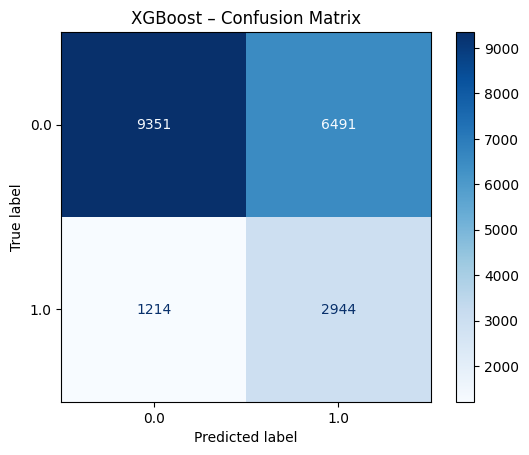

In [15]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    xgb_pipeline,
    X_test,
    y_test,
    cmap='Blues'
)
plt.title('XGBoost – Confusion Matrix')
plt.show()

In [16]:
import joblib

joblib.dump(xgb_pipeline, "xgb_model.pkl")

['xgb_model.pkl']

### Oversampling

In [17]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_score, recall_score

over_sampling = RandomOverSampler(random_state=42)
X_over, y_over = over_sampling.fit_resample(X_train, y_train)

xg_boost_over = XGBClassifier(
        n_estimators=20,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='logloss',
        random_state=42
    ).fit(X_over, y_over)
print(f"Oversampling Recall: {recall_score(y_test, xg_boost_over.predict(X_test))}")

Oversampling Recall: 0.9723424723424724


### Undersampling

In [18]:
from imblearn.under_sampling import RandomUnderSampler

uner_sampling = RandomUnderSampler(random_state=42)
X_under, y_under = uner_sampling.fit_resample(X_train, y_train)

xg_boost_under = XGBClassifier(
        n_estimators=20,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='logloss',
        random_state=42
    ).fit(X_under, y_under)
print(f"Undersampling Recall: {recall_score(y_test, xg_boost_under.predict(X_test))}")

Undersampling Recall: 0.9752284752284752


### SMOTE

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

xg_boost_smote = XGBClassifier(
        n_estimators=20,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='logloss',
        random_state=42
    ).fit(X_smote, y_smote)
print(f"SMOTE Recall: {recall_score(y_test, xg_boost_smote.predict(X_test))}")

SMOTE Recall: 0.949013949013949


### Hyperparameter Tuning

#### Grid Search

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.3, 0.5],
    'subsample': [0.8]
}

In [21]:
gs = GridSearchCV(xg_boost_under, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

gs.fit(X_train, y_train)

print("Best Parameters:", gs.best_params_)
print("Grid Search Score:", gs.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Grid Search Score: 0.6683749845836745


In [22]:
y_pred_best = gs.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

         0.0       0.89      0.68      0.77     15842
         1.0       0.35      0.67      0.46      4158

    accuracy                           0.67     20000
   macro avg       0.62      0.67      0.61     20000
weighted avg       0.77      0.67      0.70     20000



#### Cross Validation

In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import scipy.stats as st

ratio = (y == 0).sum() / (y == 1).sum()

model_cv = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.5,
    scale_pos_weight=ratio,
    tree_method='hist',
    random_state=42
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    model_cv,
    X,
    y, 
    cv=cv,
    scoring='recall',
    n_jobs=-1
)

tc = st.t.ppf(1-((1-confidence_level)/2), df=folds-1)

print(f"Recall promedio: {scores.mean():.4f} (+/- tc* {scores.std(ddof=1)/np.sqrt(5):.4f})")

NameError: name 'st' is not defined

In [ ]:
def objective(trial, confidence_level, folds):

    # First, we define the grid with values to consider when train several possible combinations.
    # Now we specify a range/list of values to try for each hyper-parameter, and we let optuna to decide which
    # combination to try.
    n_estimators = trial.suggest_int("n_estimators", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 4, 16)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 250, 1000)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    xg_boost = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='logloss',
        random_state=42

    # Here the parameter "cv" specifies the number of folds K
    scores = cross_val_score(xg_boost, X_train_norm_df, y_train, cv=folds) # The scores provided will be the R2 on each hold out fold
    mean_score = np.mean(scores)
    sem = np.std(scores, ddof=1) / np.sqrt(folds)

    tc = st.t.ppf(1-((1-confidence_level)/2), df=folds-1)
    lower_bound = mean_score - ( tc * sem )
    upper_bound = mean_score + ( tc * sem )

    # Here, we're storing confidence interval for each trial. It's not possible for the objective function to return
    # multiple values as Optuna uses the only returned value to find the best combination of hyperparameters.
    trial.set_user_attr("CV_score_summary", [round(lower_bound,4), round(np.mean(scores),4), round(upper_bound,4)])

    return np.mean(scores)


In [ ]:
confidence_level = 0.95
folds = 10

start_time = time.time()
study = optuna.create_study(direction="maximize") # We want to have the maximum values for the R2 scores
study.optimize(lambda trial: objective(trial, confidence_level, folds), n_trials=45)
end_time = time.time()

print("\n")
print(f"Time taken to find the best combination of hyperparameters among the given ones: {end_time - start_time: .4f} seconds")
print("\n")
print("The best combination of hyperparameters found was: ", study.best_params)
print(f"The best R2 found was: {study.best_value: .4f}")

In [ ]:
results = sorted([(index,
  trial.user_attrs['CV_score_summary'][0],
  trial.user_attrs['CV_score_summary'][1],
  trial.user_attrs['CV_score_summary'][2]) for index, trial in enumerate(study.trials)], key=lambda x: x[2], reverse=True)

print(f"The R2 confidence interval for the best combination of hyperparameters is: {results[0][1:]}")
